In [1]:
#import packages
import numpy as np
import pandas as pd
import math as mt
from itertools import starmap
import sys 
# Printing all values of array without truncation 
np.set_printoptions(threshold=sys.maxsize) 
import numpy_indexed as npi
import random
import time

from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

""" for multiprocess, paralel find inspiration here """ \
"""https://www.youtube.com/watch?v=IPMcV_IXtX4"""

#think about paralelising different parameter simulations


' for multiprocess, paralel find inspiration here https://www.youtube.com/watch?v=IPMcV_IXtX4'

In [3]:
def initialise(N,nt,beta0,beta1,alpha0,alpha1):
    lattice = np.zeros(nt,dtype=object)
    lattice[nt-N:] = 1
    random.shuffle(lattice)
    sq_nt=int(mt.sqrt(nt))
    lattice = lattice.reshape(sq_nt,sq_nt)
    positions=np.where(lattice==1)
    #print(lattice)
    
    cols=['ag_id','beta0','beta1','alpha0','alpha1','rank_id','i','j','ij','n_offs','id_mother','rank_mother','matril','gs','alive','juvenile']
    agents = np.zeros(N*len(cols),dtype='int')
    agents = agents.reshape(N,len(cols))
    agents = pd.DataFrame(agents,columns=cols)
    agents['ag_id']=list(range(N))
    agents['beta0']= beta0#solitbeta if beta is None else beta #should be all solitary to start or the parameters I set
    agents['beta1']= beta1 #solitbeta if beta is None else beta
    agents['alpha0']= alpha0
    agents['alpha1']= alpha1
    agents['rank_id']=1
    agents['i']=positions[0]
    agents['j']=positions[1]
    agents['ij']=agents['i'].astype(str)+"-"+agents['j'].astype(str)
    agents['n_offs']=0
    agents['id_mother']=None
    agents['rank_mother']=None
    agents['matril']=list(range(N))
    agents['gs']=1
    agents['alive']=1
    agents['juvenile']=0
    agents['floater']=0
    agents['generation']=0
    agents = agents.astype(dtype= {'ag_id':"Int64",
                                   'beta0':"float64",'beta1':"float64",'alpha0':"float64",'alpha1':"float64",
                                   'rank_id':"Int64",'i':"Int64",'j':"Int64",'ij':'str',
                                   'n_offs':"Int64",'id_mother':"Int64",'rank_mother':"Int64",
                                   'matril':"Int64",'gs':"Int64",'alive':"Int64",'juvenile':"Int64",
                                   'floater':"Int64",'generation':"Int64"})
    #print(agents)
    
    
    #lattice is to keep the spatial information with low memory, terr will only contain the territories with agents
    # BREEDING TERRITORIES' matrix. The bter correspond to the positions asigned in lattice[x,y]==1. 
    
    cols=['terr_id','i','j','ij','gs','ranklist']
    terr = np.zeros(N*len(cols),dtype='int')
    terr = terr.reshape(N,len(cols))
    terr = pd.DataFrame(terr,columns=cols)
    terr['terr_id']=list(range(N))
    terr['i']=positions[0]
    terr['j']=positions[1]
    terr['ij']=terr['i'].astype(str)+"-"+terr['j'].astype(str) #if all territories where in([1 if x==True else 0 for x in terr['ij'].isin(agents['ij'])])
    terr['gs']=1
    rnkl=[]
    [rnkl.append([1]) for i in range(N)]
    #print(rnkl)
    terr['ranklist']=rnkl
    terr = terr.astype(dtype= {'terr_id':"Int64",'i':"Int64",'j':"Int64",'ij':'str','gs':"Int64"})
    #print(terr)
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("INITIALISE",agents,terr,"repetition ij",boolean,sep="\n")
    
    return agents, terr, lattice, #floaterlist#, TotoffRank, AbsoffRank, ReloffRank, total, Alive


def actualise(agents,terr,lattice):
    #separate into dead ids and floaters and residents 
    #np.split(agents, np.where(agents.alive == 0 | agents.floater==1)[0] + 1)
    #agents.loc[:,"floater"]=0
    deadfloat=np.where((agents.alive == 0) | (agents.floater==1))[0]
    if(len(deadfloat)>0):
        nores=agents.loc[deadfloat,]
        agents=agents.loc[np.where((agents.alive == 1) & (agents.floater==0))[0],]
   
    #group size: 
    #count ids per territory and add the count in the terr and agents df
    gs_terr=agents.groupby('ij')['ag_id'].count()
    agents.loc[:,'gs'] = agents.ij.map(gs_terr).values
    agents.loc[:,'gs'] = agents['gs'].fillna (0)
    terr.loc[:,'gs'] = terr.ij.map(gs_terr).values
    terr.loc[:,'gs'] = terr['gs'].fillna (0)
    intvector = np.vectorize(int)
    #terr.loc[:,"gs"]=intvector(terr["gs"].values)
    #print(agents,terr,sep="\n")

    #actualise ranks
    def sortgroups(data,var):
        x=data.sort_values(var)
        x[var]=range(1,len(x)+1)
        return(x)        
    agents=agents.groupby('ij').apply(lambda x: sortgroups(x,'rank_id')).reset_index(drop=True)
    terr_rank=agents.groupby('ij')['rank_id'].apply(list)
    terr.loc[:,'ranklist'] = terr.ij.map(terr_rank)
    isna = terr['ranklist'].isna()
    terr.loc[isna, 'ranklist'] = pd.Series([[]] * isna.sum()).values
    #restore agents in id order
    agents=agents.sort_values(["ag_id"],ascending=True).reset_index(drop=True)
    #terrij=terr.loc[:,"ij"].split("-")
    ijij = terr.ij.str.split("-",expand=True,)
    
    #print(ijij)
    #actualise lattice    
    lattice[intvector(ijij.loc[:,0]),intvector(ijij.loc[:,1])]=terr["gs"]
    
    if(len(deadfloat)>0):
        agents=agents.append(nores).sort_values(["ag_id"],ascending=True).reset_index(drop=True)
    #print(agents)
    
    #print(agents,terr,lattice,sep="\n")
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("ACTUALISE",agents,terr,"repetition ij",boolean,sep="\n")

    return agents, terr, lattice

def dispersal(agents,terr):
    juvidx=np.where((agents.alive==1)&(agents.juvenile==1))
    if(len(juvidx[0])>0):
        #print("ENTRY",agents,sep='\n')
        juv=agents.loc[juvidx]
        adultdom=agents.loc[np.where((agents.alive==1)&(agents.juvenile==0) & (agents.rank_id==1) & (agents.floater==0))]
        #print("JUVENILES",juv,"DOMINANTS",adultdom,sep='\n')
        addomidx=adultdom.reset_index().set_index('ij').loc[juv.ij, 'index'].values
        #print("DOMINANTS IDX",addomidx,sep='\n')
        #print("lens",len(juv),len(adultdom),len(addomidx))
        GS=agents.loc[addomidx]["gs"].values.astype("Int64")
        b0=agents.loc[juvidx]["beta0"].values
        b1=agents.loc[juvidx]["beta1"].values
        a0=agents.loc[addomidx]["alpha0"].values
        a1=agents.loc[addomidx]["alpha1"].values
        #print("b0",b0,"b1",b1,"a0",a0,"a1",a1,"GS",GS,sep="\n")
        #print("b0",b0.dtype,"b1",b1.dtype,"a0",a0.dtype,"a1",a1.dtype,"GS",GS.dtype,sep="\n")
        pdecide=1/(1+np.exp(b0+b1*GS)) #prob offspring decides to stay
        paccept=1/(1+np.exp(a0+a1*GS)) #prob highest ranking female accepts
        pjoin=pdecide*paccept
        #pjoin[1]=1
        #print(pdecide,paccept,pjoin,sep="\n")
        pn=np.random.rand(len(pjoin))
        pjoinmin=pjoin-pn
        stay=np.where(pjoinmin>=0)
        go=np.where(pjoinmin<0)    

        #set ids in their territory 
        if len(stay)>0:
            juvstayidx=juvidx[0][stay]
            addomstayidx=addomidx[stay]
            #set rank to last in all juveniles staying in smae terr to be actualised in actualise()
            terrjuvidx=terr.reset_index().set_index('ij').loc[agents.ij[juvstayidx], 'index'].values
            agents.loc[juvstayidx,"rank_id"]=terr.ranklist[terrjuvidx].map(max).values

        #set as floaters those that didn't stay
        if len(go)>0:
            juvgoidx=juvidx[0][go]
            addomgoidx=addomidx[go]
            agents.loc[juvgoidx,"ij"]=None #set as floaters
            agents.loc[juvgoidx,"floater"]=1
            agents.loc[juvgoidx,"gs"]=None

        agents.loc[:,"juvenile"]=0
        if(prntlast==True):
            boolean = not terr["ij"].is_unique
            print("DISPERSAL",agents,terr,"repetition ij",boolean,sep="\n")
    return(agents)

def survival(agents,terr,Sflo,Sb,y,Smax):
    resid=np.where((agents.alive == 1) & (agents.floater==0))[0]
    Sbv=np.repeat(Sb,len(resid))
    yv=np.repeat(y,len(resid))
    Smaxv=np.repeat(Smax,len(resid))
    GS=agents.loc[resid,"gs"].values.astype("Int64")
    respsur=Sbv+(Smaxv-Sbv)*(1-np.exp(-yv*GS))
    
    n1=np.random.rand(len(respsur))
    resmin=respsur-n1
    idxresdead=resid[np.where(resmin<0)]
    #print(agents)
    #print(resid,len(resid),len(respsur),sep="\n")
    
    floater=np.where((agents.alive == 1) & (agents.floater==1))[0]    
    flopsur=np.repeat(Sflo,len(floater))#1-prob dy
    n2=np.random.rand(len(flopsur))
    flmin=flopsur-n2
    idxflodead=floater[np.where(flmin<0)]
    #print(floater,len(floater),len(flopsur),sep="\n")
    #print(agents)
    agents.loc[idxresdead,"alive"]=0
    agents.loc[idxflodead,"alive"]=0
    
    #print(respsur,n1,resmin,idxresdead,flopsur,n2,flmin,idxflodead,sep="\n")
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("SURVIVAL",agents,terr,"repetition ij",boolean,sep="\n")
    return agents

def colonise(agents,terr,lattice):
    floater=np.where((agents.alive == 1) & (agents.floater==1))[0]
    print("floater",floater)
    print("len",len(floater))
    if(len(floater)>0):
        positions=np.where(lattice==0)
        if(len(positions[0])<len(floater)):#if there are more floaters than empty territories
            colon=np.random.choice(floater, len(positions[0]), replace=False)
        else: colon=floater.copy()
        

        #choose randomly the indices from territories
        idxnewterr=np.random.choice(range(len(positions[0])),len(colon), replace=False)
        print("colon",colon,sep="\n")
        print("idxnewterr",idxnewterr,sep="\n")
        agents.loc[colon,'rank_id']=1
        agents.loc[colon,'i']=positions[0][idxnewterr].astype('int')
        agents.loc[colon,'j']=positions[1][idxnewterr].astype('int')
        #display(agents)
        #print("colons",colon,sep="\n")
        #function from @jan-glx in stackoverflow. Allows to correct for problems arising when only one colon is attempting to settle
        def paste(*args, sep = " ", collapse = None):
            import itertools
            l = [list(arg) if isinstance(arg, str) else arg if hasattr(arg, '__len__') else list(str(arg)) for arg in args]
            l = list(itertools.islice((sep.join(parts) for parts in zip(*(itertools.cycle(map(str, e)) for e in l))), (max((len(x) for x in l)))))
            if collapse is not None:
                l = collapse.join(l)
            return l
        agents.loc[colon,'ij']=paste(agents.loc[colon,'i'].astype('int').astype('str'),agents.loc[colon,'j'].astype('int').astype('str'),sep="-")#(agents.loc[colon,'i'].astype('int').astype('str')+"-"+agents.loc[colon,'j'].astype('int').astype('str')).values
        agents.loc[colon,'gs']=1
        agents.loc[colon,'floater']=0


        #create new territories
        cols=['terr_id','i','j','ij','gs','ranklist']
        tr_id=range(max(terr.terr_id),max(terr.terr_id)+len(colon))
        iji=agents.loc[colon,'i'].values.astype('int')
        ijj=agents.loc[colon,'j'].values.astype('int')
        ijij=agents.loc[colon,'ij']
        gs=agents.loc[colon,'gs']
        rnkl=[]
        [rnkl.append([1]) for i in range(len(colon))]

        new_terr= pd.DataFrame([tr_id,iji,ijj,ijij,gs,rnkl])
        new_terr = new_terr.transpose()
        new_terr.columns = ['terr_id','i','j','ij','gs','ranklist']
        #print("new",new_terr,sep="\n")
        #print("bef",terr,sep="\n")
        terr=terr.append(new_terr).reset_index(drop=True)
        terr=terr.loc[np.where(terr.gs>0)[0],:].reset_index(drop=True)
        terr = terr.astype(dtype= {'terr_id':"Int64",'i':"Int64",'j':"Int64",'ij':'str','gs':"Int64"})
    
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("COLONISE",agents,terr,"repetition ij",boolean,sep="\n")
    return agents, terr


def reproduce(agents,terr,F0,a,s,mu,sigma):
    #print("ENTRY",agents,sep="\n")
    #If you are resident female, alive, and you were not born this year:
    #display(agents)
    idx=np.where((agents['floater']==0) & (agents['alive']==1))
    #apply prob reprod
    GS=agents.loc[idx]["gs"].values.astype("Int64")             #Set group size
    R=agents.loc[idx]['rank_id'].values                         #Set Rank
    #print(GS,R,sep="\n")
    prep=(F0*(1-(a*GS))*R**(-s))/2             #Apply reprod function divide by two to account for the fact that half offspring is male(not modeled)
    #print(pd.concat([pd.DataFrame(R),pd.DataFrame(prep)],axis=1))
    
    pn=np.random.rand(len(prep))
    prepmin=prep-pn
    #print("prepmin",prepmin,sep="\n")
    idxrep=idx[0][np.where(prepmin>=0)]
    agents.loc[idxrep,"n_offs"]=agents.loc[idxrep]["n_offs"].values+1
    #print("agents_n_offs",agents,sep="\n")
    
    #create columns, then put them together and append to df
    ag_id=list(range(agents.ag_id.max()+1,agents.ag_id.max()+1+len(idxrep)))
    
    b0=agents.loc[idxrep,"beta0"]+np.random.normal(mu, sigma, len(idxrep))
    b1=agents.loc[idxrep,"beta1"]+np.random.normal(mu, sigma, len(idxrep))
    a0=agents.loc[idxrep,"alpha0"]+np.random.normal(mu, sigma, len(idxrep))
    a1=agents.loc[idxrep,"alpha1"]+np.random.normal(mu, sigma, len(idxrep))

    iji=agents.loc[idxrep,"i"].values
    ijj=agents.loc[idxrep,"j"].values
    ijij=agents.loc[idxrep,"ij"].values
    #print("lenag_id",len(ag_id))
    #print("lenb0",len(b0))
    #print("leniji",len(iji))
    #print("lenijj",len(ijj))
    #print("lenijij",len(ijij))
    #print("ij etc",iji,ijj,ijij,sep="\n")
    
    
    n_offs=np.repeat(0,len(idxrep))
    id_mother=agents.loc[idxrep,"ag_id"]
    #print("ijij",ijij,sep="\n")
    ijij_terr=terr.reset_index().set_index('ij').loc[ijij, 'index'].values
    #print("ijij_terr",ijij_terr,sep="\n")
    #print("terr",terr,sep="\n")
    #print("ranlist_ijij_terr",terr.loc[ijij_terr,"ranklist"].map(max).values+1,sep="\n")

    rank_id=terr.loc[ijij_terr,"ranklist"].map(max).values+1    
    rank_mother=agents.loc[idxrep,'rank_id']
    matril=agents.loc[idxrep,"matril"]
    gs=agents.loc[idxrep,"gs"]
    alive=np.repeat(1,len(idxrep))
    juvenile=np.repeat(1,len(idxrep))
    floater=np.repeat(0,len(idxrep))
    gener=agents.loc[idxrep,"generation"]+1
    #[ag_id,b0,b1,a0,a1,rank_id,iji,ijj,ijij,n_offs,id_mother,rank_mother,matril,gs,alive,just_dead,juvenile].map(pd.DataFrame)
    new_ag= pd.DataFrame([ag_id,b0,b1,a0,a1,rank_id,n_offs,id_mother,rank_mother,matril,gs,alive,juvenile,floater,gener])
    #new_ag=new_ag.astype(float)
    new_ag = new_ag.transpose()
    new_ag.columns = ['ag_id','beta0','beta1','alpha0','alpha1','rank_id','n_offs','id_mother','rank_mother','matril','gs','alive','juvenile','floater','generation']
    #print(new_ag)
    new_ag=new_ag.assign(i=iji,j=ijj,ij=ijij)
    
    new_ag = new_ag.astype(dtype= {'ag_id':"Int64",
                                   'beta0':"float64",'beta1':"float64",'alpha0':"float64",'alpha1':"float64",
                                   'rank_id':"Int64",'i':"Int64",'j':"Int64",'ij':'str',
                                   'n_offs':"Int64",'id_mother':"Int64",'rank_mother':"Int64",
                                   'matril':"Int64",'gs':"Int64",'alive':"Int64",'juvenile':"Int64",
                                   'floater':"Int64",'generation':"Int64"
                                  })
    #print("new_ag",new_ag,sep="\n")
    
    agents=agents.append(new_ag,sort=True).reset_index(drop=True)
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("REPRODUCE",agents,terr,"repetition ij",boolean,sep="\n")
    return agents

def repsuc(data):
    #print(data)
    data= data[data.columns.difference(['ij'])]
    #data=data.astype(float)
    #df1 = data.pivot_table(index='rank_id',columns=,values='n_offs',aggfunc='mean')
    #print(data.dtypes)
    nbag=len(data)
    #df1.groupby(['State','Product'])['Sales'].mean()

    means0=data.groupby('rank_id')['n_offs'].mean().reset_index()
    means0=means0.assign(var='rank_id').rename(columns={'rank_id': "val"})
    means00=data.groupby('rank_mother')['n_offs'].count().reset_index()
    means00=means00.assign(var='rank_mother').rename(columns={'rank_mother': "val"})
    
    #print(means0)
    ceilv=np.vectorize(np.ceil)
    data=data.assign(beta0_c=ceilv(data.beta0), beta1_c=ceilv(data.beta1), alpha0_c=ceilv(data.alpha0),alpha1_c=ceilv(data.alpha1))
    means1=data.groupby('beta0_c')['n_offs'].mean().reset_index()
    means1=means1.assign(var='beta0_c').rename(columns={'beta0_c': "val"})
    means2=data.groupby('beta1_c')['n_offs'].mean().reset_index()
    means2=means2.assign(var='beta1_c').rename(columns={'beta1_c': "val"})
    means3=data.groupby('alpha0_c')['n_offs'].mean().reset_index()
    means3=means3.assign(var='alpha0_c').rename(columns={'alpha0_c': "val"})
    means4=data.groupby('alpha1_c')['n_offs'].mean().reset_index()
    means4=means4.assign(var='alpha1_c').rename(columns={'alpha1_c': "val"})

    #print(means1)
    #print(means4)
    # concatenating along rows
    means = pd.concat([means0,means00,means1,means2,means3,means4], axis=0).reset_index(drop=True)
    #print(means)
    means = means.assign(nbagents=nbag)
    
    means = means.astype(dtype= {'n_offs':"float64"
                                  })
    
    #print(means)
    #print(nono)
    return(means)

def run(T,N,nt,beta0,beta1,alpha0,alpha1,Sflo,Sb,y,Smax,F0,a,s,mu,sigma_min,sigma_max,nsigma):
    sigmas = np.linspace(sigma_min, sigma_max, num=nsigma, endpoint=True, retstep=False, dtype=float)
    #print(sigmas)
    results = []
    #print(results)
    for sigma_idx in range(len(sigmas)):       
        agents, terr, lattice=initialise(N,nt,beta0,beta1,alpha0,alpha1)
        for t in range(T):
            #print(t)
            #print(range(T))
            agents=dispersal(agents,terr)
            agents, terr, lattice=actualise(agents,terr,lattice)
            #baseline survival probability lone breeder=0.8 with these param combs
            #agents, terr, lattice=initialise(N,nt,beta0,beta1,alpha0,alpha1)
            agents=survival(agents,terr,Sflo,Sb,y,Smax)
            agents, terr, lattice=actualise(agents,terr,lattice)
            agents, terr=colonise(agents,terr,lattice)
            agents, terr, lattice=actualise(agents,terr,lattice)
            agents=reproduce(agents,terr,F0,a,s,mu,sigmas[sigma_idx])
            agents, terr, lattice=actualise(agents,terr,lattice)
            #results
            #if its a multiple of 500 generations
            if(t % 10 == 0):
                result=agents.groupby('generation').apply(repsuc).reset_index()
                result=result[result.columns.difference(['level_1'])]
                result.set_index('generation', inplace=True)
                #result.groupby(['var','val'])['n_offs'].plot(legend=True)
                #print(result)
            if(t==(T-1)):
                result=agents.groupby('generation').apply(repsuc).reset_index()
                #print(result)
                result=result[result.columns.difference(['level_1'])]
                #print(result)
                result.set_index('generation', inplace=True)
                result=result.assign(sigma=sigmas[sigma_idx])
                #print(result)
                results.append(result) #f is an object that groups the len(b1) progressions of ReloffRank for the T loops
                #print(results)
    results=pd.concat(results)
    return(agents,results)


In [ ]:
T=200
N=40
nt=10*10 #needs to have a perfect square root
#parameters
#REPRODUCTION
F0=2 #baseline nb offspring
a=0.2 #strength gsize effect on rep
s=0.5 #strength effect hierarchy on rep
#DISPERSAL (evolving params)
beta0=-10 #intercept logit effect gs on decision offspring to stay or disperse (with current values all females disperse, "solitary species")
beta1=20  #strength effect gs on decision offspring to stay or disperse
alpha0=-10 #intercept logit effect gs on decision dominant female to stay or disperse (with current values all females are rejected, "solitary species")
alpha1=20 #strength effect gs on decision dfemale to stay or disperse
#SURVIVAL
y=0.5  #three params shape curve relating group size and survival (this config 0.8 for resid female rank1)
Sb=0.5 
Smax=0.95 #maximum survival probability in pop
Sflo=0.6 #floater survival prob

mu=0
sigma_min=1
sigma_max=10
nsigma=3

prntlast=False
#print(agents,'\n',terr,'\n',lattice)
agentss, resultss=run(T,N,nt,beta0,beta1,alpha0,alpha1,Sflo,Sb,y,Smax,F0,a,s,mu,sigma_min,sigma_max,nsigma)


floater []
len 0
floater [41 43 44 47 48 49 50 51 52 53 54 55 56 57 59 60]
len 16
colon
[41 43 44 47 48 49 50 51 52 53 54 55 56 57 59 60]
idxnewterr
[47 75 65 53 10  5 71 16 36 72 62 76 40 44 46 50]
floater [63 65 67 68 69 71 74 78 80 81 82 83 84 85 87 89]
len 16
colon
[63 65 67 68 69 71 74 78 80 81 82 83 84 85 87 89]
idxnewterr
[30 35 21 72 10 33 42 36  8 12 49 19 32 48 50 53]
floater [ 90  91  93  95  97  98  99 100 101 102 103 105 106 108 109 110 111 113
 115 116 117 118 119]
len 23
colon
[ 90  91  93  95  97  98  99 100 101 102 103 105 106 108 109 110 111 113
 115 116 117 118 119]
idxnewterr
[16  8 69 65 26 38 28  3 46 10 37 24 14 32 39 45 57 63 12 36 47 55 15]
floater [122 124 126 127 128 129 130 131 133 134 135 136 137 138 139 140 142 143
 146 147 148 149 151 152 154 155 157]
len 27
colon
[122 124 126 127 128 129 130 131 133 134 135 136 137 138 139 140 142 143
 146 147 148 149 151 152 154 155 157]
idxnewterr
[67  9 20 17 56 58 45 26 24  8 59 15 29 16 57 60 68  1 66 47  4 19 23 46

In [103]:
print(agentss)

       ag_id  alive     alpha0     alpha1      beta0      beta1  floater  \
0          0      0 -10.000000  20.000000 -10.000000  20.000000        0   
1          1      0 -10.000000  20.000000 -10.000000  20.000000        0   
2          2      0 -10.000000  20.000000 -10.000000  20.000000        0   
3          3      0 -10.000000  20.000000 -10.000000  20.000000        0   
4          4      0 -10.000000  20.000000 -10.000000  20.000000        0   
5          5      0 -10.000000  20.000000 -10.000000  20.000000        0   
6          6      0 -10.000000  20.000000 -10.000000  20.000000        0   
7          7      0 -10.000000  20.000000 -10.000000  20.000000        0   
8          8      0 -10.000000  20.000000 -10.000000  20.000000        0   
9          9      0 -10.000000  20.000000 -10.000000  20.000000        0   
10        10      0 -10.000000  20.000000 -10.000000  20.000000        0   
11        11      0 -10.000000  20.000000 -10.000000  20.000000        0   
12        12

In [104]:
resultss
str1 = "rank_id";
str2 = "_c"
rkdf=pd.Series(resultss['var']).str.contains(str1)
idx=np.where(rkdf==True)[0]
resultss_rank=resultss.iloc[idx,:]
coeffsdf=pd.Series(resultss['var']).str.contains(str2)
resultss_coeffs=resultss.iloc[np.where(coeffsdf==True)[0],:]
#print(resultss_rank,resultss_coeffs,sep="\n")

In [105]:
import altair as alt
chart = alt.Chart(resultss_rank.reset_index()).mark_line().encode(
    x=alt.X("generation:O"), #, title=None, axis=alt.Axis(labels=False, ticks=False), scale=alt.Scale(padding=1)
    y=alt.Y("n_offs:Q"), 
    color="val:O",
    row=alt.Row('sigma:O', header=alt.Header(orient='bottom'))#sort=['Thur','Fri','Sat','Sun'],
 )
    #.properties(
#     width=100
# ).configure_facet(
#     spacing=0
# ).configure_view(
#     stroke=None
# )
chart

alt.Chart(...)

sigma  var      val
0.010  rank_id  1.0    AxesSubplot(0.125,0.125;0.775x0.755)
                2.0    AxesSubplot(0.125,0.125;0.775x0.755)
0.055  rank_id  1.0    AxesSubplot(0.125,0.125;0.775x0.755)
                2.0    AxesSubplot(0.125,0.125;0.775x0.755)
0.100  rank_id  1.0    AxesSubplot(0.125,0.125;0.775x0.755)
                2.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: n_offs, dtype: object

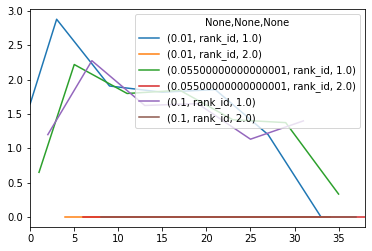

In [81]:
#print(resultss_rank)
x=resultss_rank.groupby(['generation','sigma','var','val'])['n_offs'].agg('mean').reset_index()

x.groupby(['sigma','var','val'])['n_offs'].plot(legend=True)



     generation  sigma       var   val    n_offs
0             0  0.010  alpha0_c -10.0  1.650000
1             0  0.010  alpha1_c  20.0  1.650000
2             0  0.010   beta0_c -10.0  1.650000
3             0  0.010   beta1_c  20.0  1.650000
4             0  0.055  alpha0_c -10.0  0.650000
5             0  0.055  alpha1_c  20.0  0.650000
6             0  0.055   beta0_c -10.0  0.650000
7             0  0.055   beta1_c  20.0  0.650000
8             0  0.100  alpha0_c -10.0  1.200000
9             0  0.100  alpha1_c  20.0  1.200000
10            0  0.100   beta0_c -10.0  1.200000
11            0  0.100   beta1_c  20.0  1.200000
12            1  0.010  alpha0_c -10.0  0.937500
13            1  0.010  alpha0_c  -9.0  2.000000
14            1  0.010  alpha1_c  20.0  1.333333
15            1  0.010  alpha1_c  21.0  1.571429
16            1  0.010   beta0_c -10.0  1.368421
17            1  0.010   beta0_c  -9.0  1.642857
18            1  0.010   beta1_c  20.0  2.000000
19            1  0.0

sigma  var       val  
0.010  alpha0_c  -10.0    AxesSubplot(0.125,0.125;0.775x0.755)
                 -9.0     AxesSubplot(0.125,0.125;0.775x0.755)
       alpha1_c   20.0    AxesSubplot(0.125,0.125;0.775x0.755)
                  21.0    AxesSubplot(0.125,0.125;0.775x0.755)
       beta0_c   -10.0    AxesSubplot(0.125,0.125;0.775x0.755)
                 -9.0     AxesSubplot(0.125,0.125;0.775x0.755)
       beta1_c    20.0    AxesSubplot(0.125,0.125;0.775x0.755)
                  21.0    AxesSubplot(0.125,0.125;0.775x0.755)
0.055  alpha0_c  -10.0    AxesSubplot(0.125,0.125;0.775x0.755)
                 -9.0     AxesSubplot(0.125,0.125;0.775x0.755)
       alpha1_c   20.0    AxesSubplot(0.125,0.125;0.775x0.755)
                  21.0    AxesSubplot(0.125,0.125;0.775x0.755)
       beta0_c   -10.0    AxesSubplot(0.125,0.125;0.775x0.755)
                 -9.0     AxesSubplot(0.125,0.125;0.775x0.755)
       beta1_c    20.0    AxesSubplot(0.125,0.125;0.775x0.755)
                  21.0    AxesSu

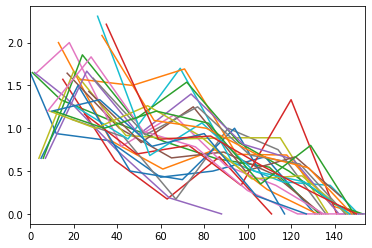

In [84]:

x=resultss_coeffs.groupby(['generation','sigma','var','val'])['n_offs'].agg('mean').reset_index()
print(x)
x.groupby(['sigma','var','val'])['n_offs'].plot()

    generation    n_offs  nbagents  val      var  sigma
0            0  1.650000        20  1.0  rank_id  0.010
1            1  2.882353        33  1.0  rank_id  0.010
2            1  0.000000        33  2.0  rank_id  0.010
3            2  1.909091        49  1.0  rank_id  0.010
4            2  0.000000        49  2.0  rank_id  0.010
5            3  1.818182        42  1.0  rank_id  0.010
6            3  0.000000        42  2.0  rank_id  0.010
7            4  1.857143        20  1.0  rank_id  0.010
8            4  0.000000        20  2.0  rank_id  0.010
9            5  1.200000        13  1.0  rank_id  0.010
10           5  0.000000        13  2.0  rank_id  0.010
11           6  0.000000         6  1.0  rank_id  0.010
12           6  0.000000         6  2.0  rank_id  0.010
13           0  0.650000        20  1.0  rank_id  0.055
14           1  2.222222        13  1.0  rank_id  0.055
15           1  0.000000        13  2.0  rank_id  0.055
16           2  1.800000        20  1.0  rank_id

alt.Chart(...)

In [137]:
#create values for parameters
b1 = np.linspace(-10, 20, num=10, endpoint=True, retstep=False, dtype=None)
#print(b1)
#print(len(b1))
T=100
N=5
#plt.plot([TotoffRank[range(0,i)], AbsoffRank[range(0,i)], ReloffRank[range(0,i)]],[i], color='black')
#plt.xlabel("b1")
#plt.ylabel("Long-term fraction of cooperators")
#plt.ylim((0,100))
#plt.grid(True)
Fitness=run(b1,N,T)

TypeError: run() missing 15 required positional arguments: 'beta0', 'beta1', 'alpha0', 'alpha1', 'Sflo', 'Sb', 'y', 'Smax', 'F0', 'a', 's', 'mu', 'sigma_min', 'sigma_max', and 'nsigma'

In [3]:
# #just to try that functions work
# agents.loc[1,"ij"]=agents.loc[0,"ij"]
# agents.loc[1,'rank_id']=2
# agents.loc[2,"ij"]=agents.loc[0,"ij"]
# agents.loc[3,"ij"]=agents.loc[0,"ij"]
# agents.loc[2,'rank_id']=0
# agents.loc[2,"juvenile"]=1
# agents.loc[3,'rank_id']=0
# agents.loc[3,"juvenile"]=1

# agents.loc[5,"ij"]=agents.loc[4,"ij"]
# agents.loc[4,'rank_id']=0
# agents.loc[4,"juvenile"]=1
# print(agents)

    ag_id  beta0  beta1  alpha0  alpha1  rank_id  i  j   ij  n_offs id_mother  \
0       0    -10     20     -10      20        1  0  0  0-0       0      None   
1       1    -10     20     -10      20        2  0  1  0-0       0      None   
2       2    -10     20     -10      20        0  0  2  0-0       0      None   
3       3    -10     20     -10      20        0  0  3  0-0       0      None   
4       4    -10     20     -10      20        0  1  0  1-0       0      None   
5       5    -10     20     -10      20        1  1  1  1-0       0      None   
6       6    -10     20     -10      20        1  1  2  1-2       0      None   
7       7    -10     20     -10      20        1  1  3  1-3       0      None   
8       8    -10     20     -10      20        1  1  4  1-4       0      None   
9       9    -10     20     -10      20        1  2  0  2-0       0      None   
10     10    -10     20     -10      20        1  2  1  2-1       0      None   
11     11    -10     20     

    ag_id  beta0  beta1  alpha0  alpha1 rank_id  i  j    ij  n_offs id_mother  \
0       0    -10     20     -10      20       1  0  0   0-0       0      None   
1       1    -10     20     -10      20       2  0  1   0-0       0      None   
2       2    -10     20     -10      20       0  0  2  None       0      None   
3       3    -10     20     -10      20       0  0  3  None       0      None   
4       4    -10     20     -10      20       0  1  0  None       0      None   
5       5    -10     20     -10      20       1  1  1   1-0       0      None   
6       6    -10     20     -10      20       1  1  2   1-2       0      None   
7       7    -10     20     -10      20       1  1  3   1-3       0      None   
8       8    -10     20     -10      20       1  1  4   1-4       0      None   
9       9    -10     20     -10      20       1  2  0   2-0       0      None   
10     10    -10     20     -10      20       1  2  1   2-1       0      None   
11     11    -10     20     

In [8]:
print(terr,lattice,sep="\n")

   terr_id  i  j   ij  gs ranklist
0        0  0  0  0-0   0       []
7        7  1  3  1-3   0       []
8        8  1  4  1-4   0       []
11      11  2  2  2-2   0       []
12      12  2  3  2-3   0       []
14      14  3  0  3-0   0       []
15      15  3  1  3-1   0       []
16      16  3  4  3-4   0       []
18      18  4  2  4-2   0       []
20      19  3  3  3-3   1      [1]
21      20  2  1  2-1   2   [1, 2]
22      21  4  1  4-1   0       []
23      22  3  2  3-2   0       []
24      23  1  2  1-2   1      [1]
25      24  2  1  2-1   2   [1, 2]
26      25  4  4  4-4   1      [1]
27      26  4  0  4-0   1      [1]
28      27  1  1  1-1   2   [1, 2]
29      28  0  4  0-4   1      [1]
30      29  1  0  1-0   1      [1]
31      30  0  3  0-3   1      [1]
32      31  1  1  1-1   2   [1, 2]
[[0 0 0 1 1]
 [1 2 1 0 0]
 [0 2 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 1]]


[ 0.08339978  0.07757623 -0.01301043 -0.46085523  0.38903767  0.38777179
  0.20647157  0.17182379  0.12098273  0.31602117 -0.26622506]


In [10]:
print(agents)

   ag_id    beta0    beta1   alpha0   alpha1 rank_id  i  j   ij n_offs  \
0      0      -10       20      -10       20       2  3  3  3-3      1   
1      1      -10       20      -10       20       2  2  1  2-1      1   
2      2      -10       20      -10       20       1  4  1  4-1      0   
3      3      -10       20      -10       20       1  3  2  3-2      0   
4      4      -10       20      -10       20       1  1  2  1-2      0   
5      5      -10       20      -10       20       1  1  1  1-0      0   
6      6      -10       20      -10       20       1  1  2  1-2      0   
7      7      -10       20      -10       20       3  2  1  2-1      0   
8      8      -10       20      -10       20       2  4  4  4-4      1   
9      9      -10       20      -10       20       1  2  0  2-0      0   
10    10      -10       20      -10       20       1  2  1  2-1      0   
11    11      -10       20      -10       20       2  4  0  4-0      1   
12    12      -10       20      -10   

In [18]:

#print(agents)



    generation  n_offs  nbagents   val       var
0            0     0.0        20   1.0   rank_id
1            0     1.0        20   2.0   rank_id
2            0     0.0        20   3.0   rank_id
3            0     0.4        20 -10.0   beta0_c
4            0     0.4        20  20.0   beta1_c
5            0     0.4        20 -10.0  alpha0_c
6            0     0.4        20  20.0  alpha1_c
7            1     0.0         8   1.0   rank_id
8            1     0.0         8 -10.0   beta0_c
9            1     0.0         8  -9.0   beta0_c
10           1     0.0         8  20.0   beta1_c
11           1     0.0         8  21.0   beta1_c
12           1     0.0         8 -10.0  alpha0_c
13           1     0.0         8  -9.0  alpha0_c
14           1     0.0         8  20.0  alpha1_c
15           1     0.0         8  21.0  alpha1_c


In [3]:
#create values for parameters
b1 = np.linspace(-10, 20, num=10, endpoint=True, retstep=False, dtype=None)
#print(b1)
#print(len(b1))
T=100
N=5
#plt.plot([TotoffRank[range(0,i)], AbsoffRank[range(0,i)], ReloffRank[range(0,i)]],[i], color='black')
#plt.xlabel("b1")
#plt.ylabel("Long-term fraction of cooperators")
#plt.ylim((0,100))
#plt.grid(True)
Fitness=run(b1,N,T)


C:\Users\User\Anaconda3\lib\site-packages\numpy_indexed\funcs.py:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.add.at(table, inverses, 1)


In [19]:
print(Fitness[1][3])
y=(Fitness[1][x][0] for x in range(0,100))
y=list(y)

[88  7  3]


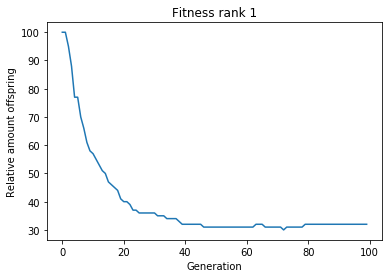

In [23]:
plt.plot(y)
plt.xlabel("Generation")
plt.ylabel("Relative amount offspring")
plt.title('Fitness rank 1')
plt.show()

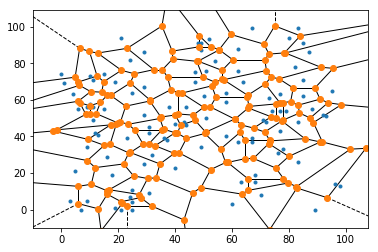

In [63]:
from scipy.spatial import Voronoi, voronoi_plot_2d

ii = np.where(lattice == 1)
p=tuple(zip(*ii))
points = p
v = Voronoi(points, qhull_options='Qbb Qc Qx')#last argument puts out the infinity points, or the fake regions in the border
voronoi_plot_2d(v)
plt.show()

In [11]:
for i, reg in enumerate(v.regions):

    print ('Region:', i)
    print ('Indices of vertices of Voronoi region:', reg)
    print ('Associated point:', points[i], '\n')

Region: 0
Indices of vertices of Voronoi region: [4, 2, 1, 0, 3]
Associated point: (0, 2) 

Region: 1
Indices of vertices of Voronoi region: [22, 10, 12, 11, 21]
Associated point: (1, 11) 

Region: 2
Indices of vertices of Voronoi region: [24, 13, 4, 3, 10, 22]
Associated point: (3, 43) 

Region: 3
Indices of vertices of Voronoi region: [26, 0, 3, 10, 12, 7, 25]
Associated point: (3, 80) 

Region: 4
Indices of vertices of Voronoi region: [26, 0, 1, 9, 8, -1]
Associated point: (4, 80) 

Region: 5
Indices of vertices of Voronoi region: [30, 28, 27, 29]
Associated point: (6, 71) 

Region: 6
Indices of vertices of Voronoi region: [37, 32, 33, 31, 35]
Associated point: (7, 41) 

Region: 7
Indices of vertices of Voronoi region: [37, 32, 5, -1, 36]
Associated point: (7, 51) 

Region: 8
Indices of vertices of Voronoi region: [40, -1, 36, 34, 38]
Associated point: (8, 86) 

Region: 9
Indices of vertices of Voronoi region: [44, 16, 15, 6, -1, 43]
Associated point: (8, 99) 

Region: 10
Indices of

In [17]:
import matplotlib.pyplot as pl
import numpy as np
import scipy as sp
import scipy.spatial
import sys

eps = sys.float_info.epsilon

n_towers = 100
towers = np.random.rand(n_towers, 2)
bounding_box = np.array([0., 100., 0., 100.]) # [x_min, x_max, y_min, y_max]

def in_box(towers, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))


def voronoi(towers, bounding_box):
    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)
    # Mirror points
    points_center = towers[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)
    # Filter regions
    regions = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                       bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor

def centroid_region(vertices):
    # Polygon's signed area
    A = 0
    # Centroid's x
    C_x = 0
    # Centroid's y
    C_y = 0
    for i in range(0, len(vertices) - 1):
        s = (vertices[i, 0] * vertices[i + 1, 1] - vertices[i + 1, 0] * vertices[i, 1])
        A = A + s
        C_x = C_x + (vertices[i, 0] + vertices[i + 1, 0]) * s
        C_y = C_y + (vertices[i, 1] + vertices[i + 1, 1]) * s
    A = 0.5 * A
    C_x = (1.0 / (6.0 * A)) * C_x
    C_y = (1.0 / (6.0 * A)) * C_y
    return np.array([[C_x, C_y]])

vor = voronoi(towers, bounding_box)




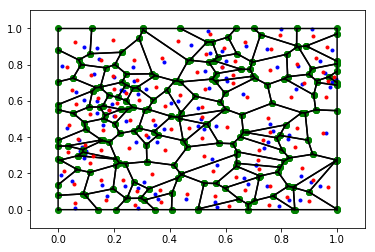

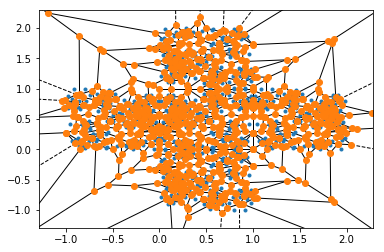

In [35]:
fig = pl.figure()
ax = fig.gca()
# Plot initial points
ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], 'b.')
# Plot ridges points
for region in vor.filtered_regions:
    vertices = vor.vertices[region, :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'go')
# Plot ridges
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-')



# Compute and plot centroids
centroids = []
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    centroid = centroid_region(vertices)
    centroids.append(list(centroid[0, :]))
    ax.plot(centroid[:, 0], centroid[:, 1], 'r.')

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
pl.savefig("bounded_voronoi.png")

sp.spatial.voronoi_plot_2d(vor)
pl.savefig("voronoi.png")

In [6]:
# vstack add a roiw to a matrix, hstack a column
#m = numpy.matrix(array2d)
#m_extended = numpy.vstack([m, newline])

l = np.zeros(100)
l=l.reshape(10,10)
l1=np.zeros(10)
l=np.vstack([l,l1])
print(l)


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [126]:
# size of the grid side
N=50

#Number of simulation rounds
T=100

#The level social herding z for Task 1
z=0.95

#Define the starting lattice with a fraction of cooperators equal to p.
#1 indicates a cooperator, 0 indicates a defector
p= 0.1

def next_round(lattice, herding_strength):
    
    N = lattice.shape[0]
    old_state = lattice.copy()

    for r in range(N):
        for c in range(N):
            #compute the number of cooperating neighbours
            #bottom neighbour + top neighbour + right neighbour + left neighbour
            nc = 0
            nc = nc + old_state[(r-1) % N,c]
            nc = nc + old_state[r,(c-1) % N]
            nc = nc + old_state[r,(c+1) % N]
            nc = nc + old_state[(r+1) % N ,c]
                       
            #compute the switching probability from D->C or C->D   
            ## P(1|0, k, sci) = 0.95*hatsk
            switch_p = 0            
            if old_state[r,c] == 0:
                #(i,j) is D -> calculate probability to switch to C  
                switch_p = herding_strength*DtoC[nc]                
            else:
                #(i,j) is C -> calculate probability to switch to D
                switch_p = herding_strength*(1-DtoC[nc])
                
            # probabilistic choice to switch
            if np.random.random() < switch_p:
                lattice[r,c] = not old_state[r,c]

    # we return the fraction of cooperators
    # think about why we don't return also the lattice
    return lattice.sum() / (N*N)




b1 = np.linspace(-10, 20, num=100, endpoint=True, retstep=False, dtype=None)

# f holds the fraction of cooperators at each simulation round
f = np.zeros(shape=T)

for b_idx in range(0,len(b1)):
    N=20
    T=100

    agents, breedter, lattice, floaterlist, TotoffRank, AbsoffRank, ReloffRank, total, Alive=initialise(N)
    
    for t in range(T):
        
        f[b_idx]=next_round(lattice, b1[b_idx])

    
# plot the long-term fraction of cooperators f, dependent on 
# the level of social herding
plt.plot( f , color='black')

plt.xlabel("Social herding")
plt.ylabel("Long-term fraction of cooperators")
plt.ylim((0,1))
plt.grid(True)  


offRank <pandas.core.groupby.DataFrameGroupBy object at 0x009BB050>
offRankprev    1
1  0
2  0
interprev1 
 0
inter 
 col6
1    410
2     95
3     23
4      4
5      2
Name: 1, dtype: int64
2
n 1
col6
1     0
2    95
3    23
4     4
5     2
Name: 1, dtype: int64


In [171]:
np.linspace(0, 1, num=50, endpoint=True, retstep=False, dtype=None)

Zs = np.linspace(0, 1, num=50, endpoint=True, retstep=False, dtype=None)

# f holds the fraction of cooperators at each simulation round
f = np.zeros(shape=T)

for z_idx in range(0,len(Zs)):
    lattice=initial_lattice.copy()
    
    for t in range(T):            
        f[z_idx]=next_round(lattice, Zs[z_idx])

    
# plot the long-term fraction of cooperators f, dependent on 
# the level of social herding
plt.plot( f , color='black')

plt.xlabel("Social herding")
plt.ylabel("Long-term fraction of cooperators")
plt.ylim((0,1))
plt.grid(True)  


4 
 [[0 1 2 2 8 0 1 1 1 0 0]
 [1 1 2 3 2 0 1 1 1 0 0]
 [2 1 3 2 4 0 1 1 0 0 0]
 [3 1 3 3 2 0 1 1 1 0 0]
 [4 0 0 0 0 0 1 0 0 0 0]
 [5 0 0 0 0 0 1 0 0 0 0]
 [6 0 0 0 0 1 1 0 0 0 0]
 [7 0 0 0 0 2 1 0 0 0 0]
 [8 0 0 0 0 0 1 0 0 0 0]
 [9 0 0 0 0 2 1 0 1 0 0]
 [10 0 0 0 0 2 1 0 0 0 0]] 
 [[0 2 2 1 [1]]
 [1 2 3 1 [1]]
 [2 3 2 0 []]
 [3 3 3 1 [1]]] 
 [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  1.]
 [ 0.  0.  0.  1.]] 

[[0 1 2 2 8 0 1 1 1 0 0]
 [1 1 2 3 2 0 1 1 1 0 0]
 [2 1 3 2 4 0 1 1 0 0 0]
 [3 1 3 3 2 0 1 1 1 0 0]
 [4 0 0 0 0 0 1 0 0 0 0]
 [5 0 0 0 0 0 1 0 0 0 0]
 [6 0 0 0 0 1 1 0 0 0 0]
 [7 0 0 0 0 2 1 0 0 0 0]
 [8 0 0 0 0 0 1 0 0 0 0]
 [9 0 0 0 0 2 1 0 0 0 0]
 [10 0 0 0 0 2 1 0 0 0 0]] 
 [[0 2 2 1 [1]]
 [1 2 3 1 [1]]
 [2 3 2 0 []]
 [3 3 3 1 [1]]] 
 [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  1.]
 [ 0.  0.  0.  1.]] 

[[0 1 2 2 8 0 1 1 1 0 0]
 [1 1 2 3 2 0 1 1 1 0 0]
 [2 1 3 2 4 0 1 1 0 0 0]
 [3 1 3 3 2 0 1 1 1 0 0]
 [4 0 0 0 0 0 1 0 0 0 0]
 [5 0 0 0 0 0 1 0 0 0 0]
 [6 0 

In [9]:
#Task 2
# function that calculates the amount of neighbors in a torus
import numpy as np
import time
from IPython.display import clear_output
# Grid size NxN
N=12
# Initial probability of alive cell
p=0.5
# Interval time
T=100
states =  np.random.binomial(1, p, size=(N,N))   
def getneigh(i,j,N,statesinput):
    n = 0
    n = n + statesinput[(i-1) % N,(j-1) % N]
    n = n + statesinput[(i-1) % N,j]
    n = n + statesinput[(i-1) % N,(j+1) % N]
    n = n + statesinput[i,(j-1) % N]
    n = n + statesinput[i,(j+1) % N]
    n = n + statesinput[(i+1) % N,(j-1) % N]
    n = n + statesinput[(i+1) % N ,j]
    n = n + statesinput[(i+1) % N,(j+1) % N]
    return n

# cell state update function
def updatestates(prevstates):
        #we create a copy of the previous state
        newstates = np.copy(prevstates)  
        for i in range(N):
            for j in range(N):
                nn = getneigh(i,j,N, prevstates)
                if nn < 2 or nn > 3:
                    newstates[i,j] = 0
                if nn == 3:
                    newstates[i,j] = 1
        return newstates

for i in range(10):
    time.sleep(float(T)/100)
    clear_output()
    nstates = updatestates(states)
    states=nstates
    print(states)

[[0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 0]
 [1 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
